In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ieee-fraud-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.simplefilter('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

## 1. Data Loading and test/train split

Load the datasets and merge them.

In [7]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df = pd.merge(df_transaction,df_identity,how="left",on="TransactionID")
print(f'Dimensions of the combined data set: {df.shape}')

del df_transaction, df_identity

Dimensions of the combined data set: (590540, 434)


Split the dataset into training and testing sets. The chosen test size is 20% of the total dataset.

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensions of the train dataset is {X_train.shape} and {y_train.shape}')
print(f'Dimensions of the validation dataset is {X_valid.shape} and {y_valid.shape}')

del df

Dimensions of the train dataset is (472432, 433) and (472432,)
Dimensions of the validation dataset is (118108, 433) and (118108,)


In [5]:
print(f"Fraud rate in the train set: {y_train.mean():.2%}")
print(f"Fraud rate in the validation set: {y_valid.mean():.2%}")

Fraud rate in the train set: 3.48%
Fraud rate in the validation set: 3.59%


## 2. Dagshub and MLflow

Just import DagsHub and MLflow for experiment tracking.

In [9]:
!pip install dagshub 
!pip install mlflow

In [38]:
import dagshub
dagshub.init(repo_owner='zhorzholianimate', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

Initialized MLflow to track repo "zhorzholianimate/IEEE-CIS-Fraud-Detection"

Repository zhorzholianimate/IEEE-CIS-Fraud-Detection initialized!

Start the experiment in MLflow.

In [39]:
import mlflow
mlflow.set_experiment("LogisticRegression_training")

<Experiment: artifact_location='mlflow-artifacts:/f1e75927ac76416996ad00aacf75ec50', creation_time=1745326966514, experiment_id='0', last_update_time=1745326966514, lifecycle_stage='active', name='LogisticRegression_training', tags={}>

## 3. Cleaning

Retrive categorical and numerical features from the training dataset.

In [9]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Categorical Features: {len(categorical_cols)}: {categorical_cols}')

Categorical Features: 31: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [10]:
print(f'Numerical Features: {len(numerical_cols)}: {numerical_cols}')

Numerical Features: 402: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V

Create a transformer class to drop features with high missing values.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNaNColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.cols_to_drop = []

    def fit(self, X, y=None):
        missing_ratio = pd.DataFrame(X).isnull().mean()
        self.cols_to_drop = missing_ratio[missing_ratio > self.threshold].index.tolist()
        return self

    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.cols_to_drop)

In [10]:
drop_na_transformer = DropHighNaNColumns(threshold=0.8)
drop_na_transformer.fit(X_train)
X_train_clean = drop_na_transformer.transform(X_train)
X_valid_clean = drop_na_transformer.transform(X_valid)

X_train_clean.shape, X_valid_clean.shape

((472432, 359), (118108, 359))

Use a costume imputer strategy to handle missing values.

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

imputer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number)),
    ('cat', SimpleImputer(strategy='constant', fill_value='Unknown'), make_column_selector(dtype_include=object))
])

X_train_clean = imputer.fit_transform(X_train_clean)
X_valid_clean = imputer.transform(X_valid_clean)

X_train_clean.shape, X_valid_clean.shape

((472432, 359), (118108, 359))

In [12]:
X_train_clean

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_37,cat__id_38,cat__DeviceType,cat__DeviceInfo
5307,2992307.0,174911.0,59.000,4988.0,334.0,150.0,226.0,315.0,87.0,42.0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
191582,3178582.0,4301977.0,23.378,3867.0,296.0,185.0,226.0,299.0,87.0,8.0,...,NotFound,New,NotFound,chrome 63.0,F,F,T,F,desktop,Unknown
260168,3247168.0,6229929.0,35.950,12577.0,268.0,150.0,166.0,476.0,87.0,8.0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
18516,3005516.0,497176.0,100.000,6019.0,583.0,150.0,226.0,126.0,87.0,8.0,...,NotFound,Found,Found,chrome 62.0,T,F,T,F,desktop,Windows
47538,3034538.0,1124702.0,75.000,16075.0,514.0,150.0,102.0,325.0,87.0,8.0,...,Found,Found,Found,chrome 62.0 for android,T,F,T,T,mobile,SM-G950U Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,2157580.0,25.000,16796.0,555.0,210.0,137.0,296.0,102.0,8.0,...,Found,Found,Found,chrome 63.0,T,F,T,T,desktop,Windows
259178,3246178.0,6213562.0,357.950,16727.0,111.0,150.0,226.0,325.0,87.0,8.0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
365838,3352838.0,9076295.0,156.000,3283.0,555.0,150.0,226.0,191.0,87.0,1.0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
131932,3118932.0,2614452.0,59.000,9500.0,321.0,150.0,226.0,204.0,87.0,8.0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


Now, let's convert categorical features into numerical ones. For now we will use Costume Encoder which works as follows: if number of different elements is small it uses one hot encoding, else it uses woe encoding.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.woe_columns = []
        self.one_hot_columns = []
        self.threshold = threshold
    def fit(self, X, y):
        cat_cols = [col for col in X.columns if X[col].dtype == 'object']
        s = X[cat_cols].nunique()
        self.woe_columns = list(s[s > self.threshold].index)
        self.one_hot_columns = list(s[s <= self.threshold].index)
        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y
        woe_mappings = {}
        iv_values = {}
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            woe_mappings[col] = woe_dict
            iv_values[col] = iv
        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self


    def transform(self, X):
        X_transformed = X.copy()
        for col in self.woe_columns:
            X_transformed[f'woe_{col}'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)
        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)
        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)
        for col in na_cols:
            pr, name = col.split("_", 1)
            if pr != "woe":
                print("Error Related to Nans")
                continue
            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed

In [14]:
encoder = CategoricalEncoder()

X_train_encoded = encoder.fit_transform(X_train_clean, y_train)
X_valid_encoded = encoder.transform(X_valid_clean)

X_train_encoded.shape, X_valid_encoded.shape

((472432, 395), (118108, 395))

In [15]:
X_train_encoded

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_36_nan,cat__id_37_T,cat__id_37_Unknown,cat__id_37_nan,cat__id_38_T,cat__id_38_Unknown,cat__id_38_nan,cat__DeviceType_desktop,cat__DeviceType_mobile,cat__DeviceType_nan
5307,2992307.0,174911.0,59.000,4988.0,334.0,150.0,226.0,315.0,87.0,42.0,...,0,0,1,0,0,1,0,0,0,0
191582,3178582.0,4301977.0,23.378,3867.0,296.0,185.0,226.0,299.0,87.0,8.0,...,0,1,0,0,0,0,0,1,0,0
260168,3247168.0,6229929.0,35.950,12577.0,268.0,150.0,166.0,476.0,87.0,8.0,...,0,0,1,0,0,1,0,0,0,0
18516,3005516.0,497176.0,100.000,6019.0,583.0,150.0,226.0,126.0,87.0,8.0,...,0,1,0,0,0,0,0,1,0,0
47538,3034538.0,1124702.0,75.000,16075.0,514.0,150.0,102.0,325.0,87.0,8.0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,2157580.0,25.000,16796.0,555.0,210.0,137.0,296.0,102.0,8.0,...,0,1,0,0,1,0,0,1,0,0
259178,3246178.0,6213562.0,357.950,16727.0,111.0,150.0,226.0,325.0,87.0,8.0,...,0,0,1,0,0,1,0,0,0,0
365838,3352838.0,9076295.0,156.000,3283.0,555.0,150.0,226.0,191.0,87.0,1.0,...,0,0,1,0,0,1,0,0,0,0
131932,3118932.0,2614452.0,59.000,9500.0,321.0,150.0,226.0,204.0,87.0,8.0,...,0,0,1,0,0,1,0,0,0,0


In [16]:
del X_valid_clean, X_train_clean

In [19]:
categorical_cols = [col for col in X_train_encoded.columns if X_train_encoded[col].dtype == 'object']
if categorical_cols:
    print(f"Categorical columns left: {categorical_cols}")
else:
    print("No categorical columns left.")

categorical_cols = [col for col in X_valid_encoded.columns if X_valid_encoded[col].dtype == 'object']
if categorical_cols:
    print(f"Categorical columns left: {categorical_cols}")
else:
    print("No categorical columns left.")

No categorical columns left.
No categorical columns left.


Search for the best hyperparameters.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [21]:
best_roc_auc = 0
best_preprocess = None
best_pipeline = None
best_y_predict = None

for threshold in [0.7, 0.8]:
    for strategy in ['most_frequent', 'constant']:
        print(f'testing threshold={threshold} and strategy={strategy}', end=' ')
        imputer = ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
            ('cat', SimpleImputer(strategy=strategy, fill_value='unknown'), make_column_selector(dtype_include=object))
        ])
        preprocess = Pipeline([
            ('highNA', DropHighNaNColumns(threshold=threshold)),
            ('imputer', imputer),
            ('encoder', CategoricalEncoder()),
            ('scaler', StandardScaler()),
        ])
        pipeline = Pipeline([
            ('preprocess', preprocess),
            ('clf', LogisticRegression(solver='saga', penalty='l2', C=0.1, max_iter=100, n_jobs=-1)),
        ])

        pipeline.fit(X_train, y_train)
        y_predict = pipeline.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, y_predict)
        print(f'and current roc_auc={roc_auc}')
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_preprocess = preprocess
            best_pipeline = pipeline
            best_y_predict = y_predict

testing threshold=0.7 and strategy=most_frequent Processing cat__ProductCD...
Processing cat__card4...
Processing cat__card6...
Processing cat__P_emaildomain...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]
and current roc_auc=0.8287596780860879
testing threshold=0.7 and strategy=constant Processing cat__ProductCD...
Processing cat__card4...
Processing cat__card6...
Processing cat__P_emaildomain...
Processing cat__M4...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]
and current roc_auc=0.8297849512400297
testing threshold=0.8 and strategy=most_frequent Processing cat__ProductCD...
Processing cat__card4...
Processing cat__card6...
Processing cat__P_emaildomain...
Processing cat__R_emaildomain...
Processing cat__id_31...
Processing cat__DeviceInfo...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['woe_cat__id_31', 'woe_cat__DeviceInfo']
and current roc_auc=0.8471519990498438
testing threshold=0.8 and strategy=constant Processing cat__ProductCD...
Processing cat__card4...
Processing cat__card6...
Processing cat__P_emaildomain...
Processing cat__R_emaildomain...
Processing cat__M4...
Processing cat__id_15...
Processing cat__id_31...
Processing cat__DeviceInfo...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['woe_cat__id_31', 'woe_cat__DeviceInfo']
and current roc_auc=0.8510000501594581


As we see the best parameters are startegy=constanr and threshold=0.8

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

imputer = ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
            ('cat', SimpleImputer(strategy="constant", fill_value='unknown'), make_column_selector(dtype_include=object))
        ])
best_preprocess = Pipeline([
    ('highNA', DropHighNaNColumns()),
    ('imputer', imputer),
    ('encoder', CategoricalEncoder()),
    ('scaler', StandardScaler()),
])

best_preprocess

Pipeline(steps=[('highNA', DropHighNaNColumns()),
                ('imputer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x786b7597ef90>),
                                                 ('cat',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x786b75832350>)])),
                ('encoder', CategoricalEncoder()),
                ('scaler', StandardScaler())])

In [20]:
X_train_encoded = best_preprocess.fit_transform(X_train, y_train)
X_train_encoded

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_36_nan,cat__id_37_T,cat__id_37_unknown,cat__id_37_nan,cat__id_38_T,cat__id_38_unknown,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_unknown,cat__DeviceType_nan
5307,-1.700744,-1.558637,-0.322223,-1.003053,-0.181902,-0.281587,0.644600,0.241728,0.069510,-0.044443,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
191582,-0.608256,-0.664988,-0.473144,-1.231887,-0.424641,2.808078,0.644600,0.075003,0.069510,-0.184160,...,0.0,2.085434,-1.785966,0.0,-0.357371,-1.785966,0.0,-0.322828,-1.787445,0.0
260168,-0.206005,-0.247521,-0.419880,0.546113,-0.603501,-0.281587,-0.814173,1.919395,0.069510,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
18516,-1.623274,-1.488856,-0.148516,-0.792592,1.408679,-0.281587,0.644600,-1.727707,0.069510,-0.184160,...,0.0,2.085434,-1.785966,0.0,-0.357371,-1.785966,0.0,-0.322828,-1.787445,0.0
47538,-1.453063,-1.352975,-0.254435,1.260171,0.967916,-0.281587,-2.370198,0.345931,0.069510,-0.184160,...,0.0,2.085434,-1.785966,0.0,2.798215,-1.785966,0.0,3.097621,-1.787445,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.085156,-1.129322,-0.466272,1.407351,1.229819,5.014982,-1.519247,0.043743,5.946749,-0.184160,...,0.0,2.085434,-1.785966,0.0,2.798215,-1.785966,0.0,-0.322828,-1.787445,0.0
259178,-0.211811,-0.251065,0.944352,1.393266,-1.606398,-0.281587,0.644600,0.345931,0.069510,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
365838,0.413741,0.368813,0.088741,-1.351100,1.229819,-0.281587,0.644600,-1.050388,0.069510,-0.212925,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
131932,-0.958099,-1.030394,-0.322223,-0.082005,-0.264944,-0.281587,0.644600,-0.914924,0.069510,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0


In [21]:
X_valid_encoded = best_preprocess.transform(X_valid)
X_valid_encoded

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_36_nan,cat__id_37_T,cat__id_37_unknown,cat__id_37_nan,cat__id_38_T,cat__id_38_unknown,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_unknown,cat__DeviceType_nan
470624,1.028302,1.035148,2.495212,-0.423723,0.757116,-0.281587,0.595974,0.991989,0.06951,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
565820,1.586619,1.652769,-0.112504,0.539377,-0.264944,-0.281587,0.644600,1.919395,0.06951,-0.217035,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
284083,-0.065745,-0.087233,-0.369039,-0.102418,-1.606398,-0.281587,0.595974,0.241728,0.06951,-0.192379,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
239689,-0.326113,-0.367973,-0.145979,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
281855,-0.078813,-0.105291,-0.114834,1.142182,0.814607,-0.281587,0.644600,0.075003,0.06951,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,0.460320,0.420403,-0.093439,-1.563603,1.229819,-0.281587,0.644600,-0.914924,0.06951,-0.184160,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
245203,-0.293773,-0.331108,-0.076492,-0.232451,1.229819,-0.281587,0.644600,-0.633577,0.06951,-0.003349,...,0.0,-0.479517,0.559921,0.0,-0.357371,0.559921,0.0,-0.322828,0.559458,0.0
450760,0.911802,0.891768,-0.320049,1.272623,-1.012325,2.808078,-1.494934,0.075003,0.06951,-0.184160,...,0.0,2.085434,-1.785966,0.0,-0.357371,-1.785966,0.0,3.097621,-1.787445,0.0
529422,1.373148,1.418394,-0.480762,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,...,0.0,2.085434,-1.785966,0.0,-0.357371,-1.785966,0.0,3.097621,-1.787445,0.0


Record the data cleaning results and evaluation metrics in MLflow.

In [26]:
import mlflow.sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_valid, best_y_predict)
avg = average_precision_score(y_valid, best_y_predict)
precision, recall, thresholds = precision_recall_curve(y_valid, best_y_predict)
pr_auc = auc(recall, precision)

with mlflow.start_run(run_name="LogisticRegression_Cleaning"):
    
    mlflow.log_metric("Current_ROC_AUC", roc_auc)
    mlflow.log_metric("Current_Average_Precision_Score", avg)
    mlflow.log_metric("Current_Precision_Recall", pr_auc)
    
    train_data_summary = pd.DataFrame(X_train_encoded).describe().T
    train_data_summary.to_csv("train_data_summary.csv", index=True)
    mlflow.log_artifact("train_data_summary.csv")
    
    valid_data_summary = pd.DataFrame(X_valid_encoded).describe().T
    valid_data_summary.to_csv("valid_data_summary.csv", index=True)
    mlflow.log_artifact("valid_data_summary.csv") 

    feature_variances = X_train_encoded.var()
    top_features = feature_variances.nlargest(10).index 
    plt.figure(figsize=(12, 6))

    # Log data summaries
    pd.DataFrame(X_train_encoded).describe().T.to_csv("train_clean_summary.csv")
    mlflow.log_artifact("train_clean_summary.csv")
    X_train_encoded[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_train_encoded Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("train_data_top_features_histograms.png")
    mlflow.log_artifact("train_data_top_features_histograms.png")
    plt.close() 
    plt.figure(figsize=(12, 6))
    X_valid_encoded[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_valid_encoded Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("valid_data_top_features_histograms.png")
    mlflow.log_artifact("valid_data_top_features_histograms.png")
    plt.close() 
    corr_matrix = pd.DataFrame(X_train_encoded[top_features]).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, xticklabels=top_features, yticklabels=top_features)
    plt.title("Correlation Heatmap of Top 10 Features")
    plt.savefig("correlation_heatmap.png")
    mlflow.log_artifact("correlation_heatmap.png")
    plt.close() 

🏃 View run LogisticRegression_Cleaning at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/3e00087bb4d44d89b6b9b403ba04f399
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## 4. Feature Engineering

In [23]:
from sklearn.feature_selection import RFE

base_model = LogisticRegression(solver='saga', penalty='l2', C=0.1, max_iter=500, n_jobs=-1)
selector = RFE(estimator=base_model, n_features_to_select=100, step=0.1)
selector.fit(X_train_encoded, y_train)
X_train_rfe = selector.transform(X_train_encoded)
X_valid_rfe = selector.transform(X_valid_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [24]:
columns = X_train_rfe.columns
print(columns)
print(f'A size of columns is {len(columns)}')

Index(['num__TransactionID', 'num__TransactionAmt', 'num__card3', 'num__C1',
       'num__C2', 'num__C3', 'num__C7', 'num__C9', 'num__C11', 'num__C13',
       'num__C14', 'num__D2', 'num__D3', 'num__D5', 'num__D11', 'num__V6',
       'num__V13', 'num__V17', 'num__V18', 'num__V19', 'num__V21', 'num__V25',
       'num__V33', 'num__V35', 'num__V36', 'num__V44', 'num__V45', 'num__V47',
       'num__V48', 'num__V50', 'num__V54', 'num__V56', 'num__V59', 'num__V62',
       'num__V67', 'num__V70', 'num__V71', 'num__V73', 'num__V82', 'num__V83',
       'num__V87', 'num__V94', 'num__V135', 'num__V170', 'num__V172',
       'num__V174', 'num__V183', 'num__V190', 'num__V191', 'num__V197',
       'num__V199', 'num__V200', 'num__V204', 'num__V205', 'num__V207',
       'num__V221', 'num__V222', 'num__V223', 'num__V228', 'num__V236',
       'num__V242', 'num__V248', 'num__V252', 'num__V253', 'num__V257',
       'num__V258', 'num__V261', 'num__V262', 'num__V264', 'num__V267',
       'num__V268', 'num__V

In [6]:
columns = ['num__TransactionID', 'num__TransactionAmt', 'num__card3', 'num__C1',
       'num__C2', 'num__C3', 'num__C7', 'num__C9', 'num__C11', 'num__C13',
       'num__C14', 'num__D2', 'num__D3', 'num__D5', 'num__D11', 'num__V6',
       'num__V13', 'num__V17', 'num__V18', 'num__V19', 'num__V21', 'num__V25',
       'num__V33', 'num__V35', 'num__V36', 'num__V44', 'num__V45', 'num__V47',
       'num__V48', 'num__V50', 'num__V54', 'num__V56', 'num__V59', 'num__V62',
       'num__V67', 'num__V70', 'num__V71', 'num__V73', 'num__V82', 'num__V83',
       'num__V87', 'num__V94', 'num__V135', 'num__V170', 'num__V172',
       'num__V174', 'num__V183', 'num__V190', 'num__V191', 'num__V197',
       'num__V199', 'num__V200', 'num__V204', 'num__V205', 'num__V207',
       'num__V221', 'num__V222', 'num__V223', 'num__V228', 'num__V236',
       'num__V242', 'num__V248', 'num__V252', 'num__V253', 'num__V257',
       'num__V258', 'num__V261', 'num__V262', 'num__V264', 'num__V267',
       'num__V268', 'num__V269', 'num__V271', 'num__V274', 'num__V281',
       'num__V283', 'num__V284', 'num__V296', 'num__V311', 'num__V312',
       'num__id_01', 'num__id_02', 'num__id_17', 'woe_cat__ProductCD',
       'woe_cat__card4', 'woe_cat__card6', 'woe_cat__P_emaildomain',
       'woe_cat__R_emaildomain', 'woe_cat__id_31', 'woe_cat__DeviceInfo',
       'cat__M3_T', 'cat__M5_T', 'cat__M5_unknown', 'cat__M6_T',
       'cat__M6_unknown', 'cat__id_12_NotFound', 'cat__id_16_unknown',
       'cat__id_29_NotFound', 'cat__id_35_T', 'cat__id_37_T']

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return X[self.columns]

In [26]:
selector = ColumnSelector(columns=columns)
selector.fit_transform(X_train_encoded)

,num__TransactionID,num__TransactionAmt,num__card3,num__C1,num__C2,num__C3,num__C7,num__C9,num__C11,num__C13,...,cat__M3_T,cat__M5_T,cat__M5_unknown,cat__M6_T,cat__M6_unknown,cat__id_12_NotFound,cat__id_16_unknown,cat__id_29_NotFound,cat__id_35_T,cat__id_37_T
5307,-1.700744,-0.322223,-0.281587,-0.090256,-0.091973,-0.036011,-0.045973,-0.208847,-0.097695,-0.243633,...,1.161145,2.117912,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
191582,-0.608256,-0.473144,2.808078,-0.097725,-0.091973,-0.036011,-0.029813,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,2.814915,-0.389051,2.085434
260168,-0.206005,-0.419880,-0.281587,-0.060379,-0.066138,-0.036011,-0.045973,-0.088777,-0.065949,-0.112188,...,-0.861219,-0.472163,0.828076,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
18516,-1.623274,-0.148516,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.087113,-0.235901,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,-0.512932,-1.889161,-0.355251,2.570359,2.085434
47538,-1.453063,-0.254435,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,-0.355251,2.570359,2.085434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.085156,-0.466272,5.014982,-0.090256,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.251365,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,-0.512932,-1.889161,-0.355251,2.570359,2.085434
259178,-0.211811,0.944352,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
365838,0.413741,0.088741,-0.281587,-0.060379,-0.072597,-0.036011,-0.045973,-0.148812,-0.087113,-0.034867,...,1.161145,-0.472163,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
131932,-0.958099,-0.322223,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.088777,-0.076531,-0.197240,...,-0.861219,2.117912,-1.207619,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517


In [27]:
with mlflow.start_run(run_name="LogisticRegression_Feature_Engineering"):
    pd.DataFrame(X_train_rfe).describe().T.to_csv("train_data_summary_rfe.csv")
    mlflow.log_artifact("train_data_summary_rfe.csv")
    
    pd.DataFrame(X_valid_rfe).describe().T.to_csv("valid_data_summary_rfe.csv")
    mlflow.log_artifact("valid_data_summary_rfe.csv")

    np.save("selected_columns.npy", columns.to_numpy())
    mlflow.log_artifact("selected_columns.npy")

🏃 View run LogisticRegression_Feature_Engineering at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/231a8ac3a18445af9576a3dabd30dd05
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


## 5. Model Training. Final Pipiline

See how the SAGA solver performs.

In [23]:
pipeline = Pipeline([
    ('cleaner', best_preprocess),
    ('selector', ColumnSelector(columns=columns)),
    ('model', LogisticRegression(solver='saga', max_iter=2000, n_jobs=-1)),
    ])

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(f'roc_auc={roc_auc}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


roc_auc=0.8576292908478665


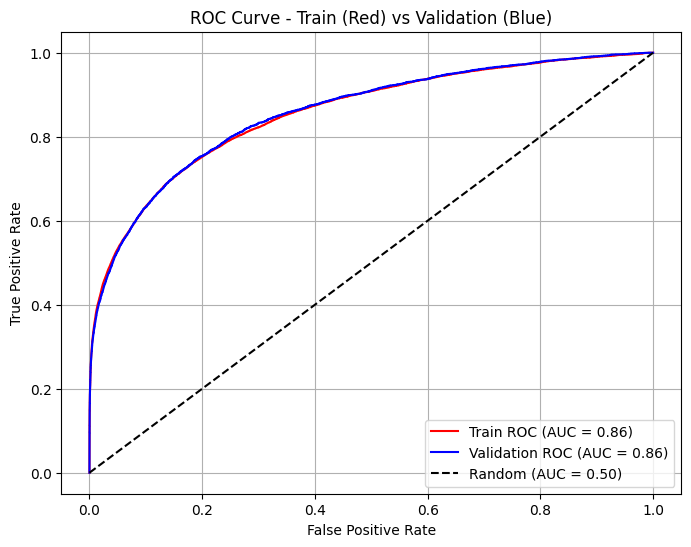

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
auc_train = auc(fpr_train, tpr_train)
auc_valid = auc(fpr_valid, tpr_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Log the model on MLflow.

2025/04/24 15:57:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


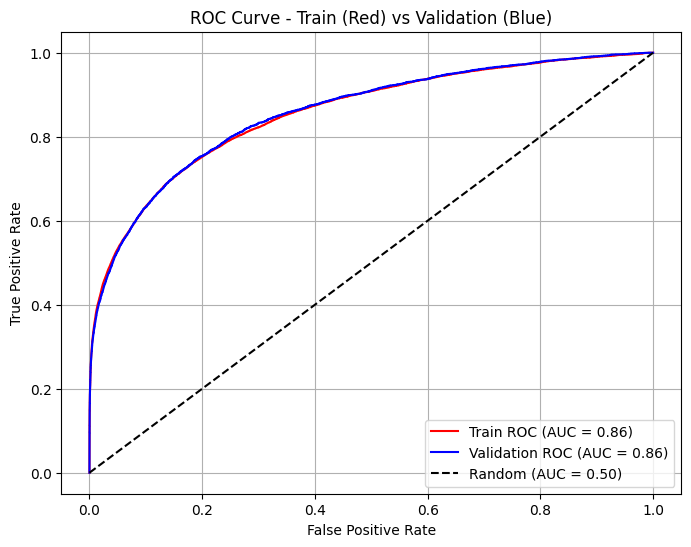

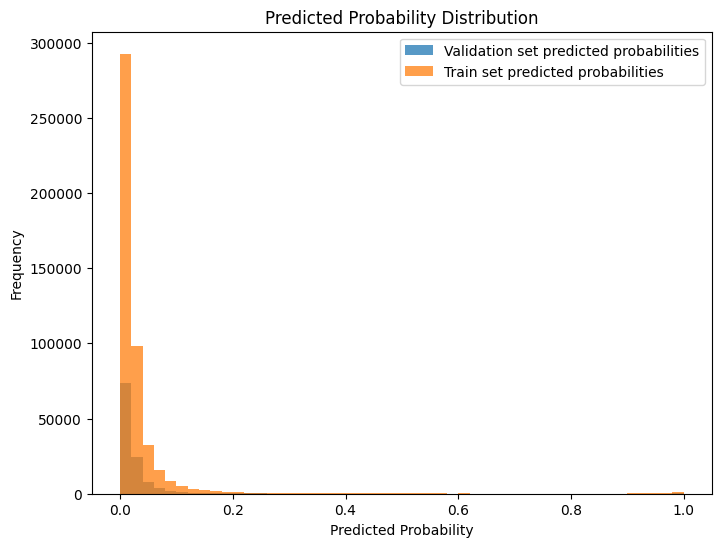

🏃 View run LogisticRegresion_Model at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/9e7c6b7f863747309fdbf4ae46a9011e
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [44]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

with mlflow.start_run(run_name='LogisticRegresion_Model'):

    mlflow.sklearn.log_model(pipeline, "logistic_regression_model")
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("preprocess_steps", [name for name, _ in best_preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "100")
